# Word Counts

Problem: okay counts are wrong

In [25]:
import pandas as pd
import sqlite3
import os
import numpy as np


from helpers.normalization import remove_punctuation, remove_punctuation_and_newlines, remove_capitalization
from helpers.statistical_tests import run_t_test_on_gender, compare_genders

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
prompts = pd.read_sql("SELECT ep.*, u.age, u.work_exp_years FROM expanded_prompts ep JOIN users u ON ep.user_id = u.user_id", conn)

## Clean, filter and normalize

In [26]:
prompts = prompts[prompts['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]

prompts = prompts.dropna(subset=['conversational'])
prompts = prompts[prompts['conversational'].str.strip() != '']
prompts = prompts.dropna(subset=['conversational'])

#prompts['conversational'] = prompts['conversational'].apply(remove_punctuation_and_newlines)
prompts['conversational'] = prompts['conversational'].apply(remove_capitalization)

## Combine per user

In [27]:
user_prompts = (
    prompts
    .fillna({'work_exp_years': 'None'})
    .groupby(['user_id', 'gender', 'age', 'work_exp_years'])['conversational']
    .apply(' '.join)
    .reset_index()    # Reset index to create a DataFrame
)
user_prompts['n_words'] = user_prompts['conversational'].apply(lambda x: len(x.split()))


## Helper functions and types

In [38]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
import seaborn as sns
from helpers.occurences import count_occurrences


def count(df, group_name, word_types, word_lists):
    for word_type, word_list in zip(word_types, word_lists):
        for word in word_list:
            df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
        df[word_type] = df[word_list].sum(axis=1)
    df[group_name] = df[word_types].sum(axis=1)
    return df

gender_palette = {'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'}
age_palette = {'19-25': 'red', '26-30': 'orange', '31-35': 'yellow', '36-40': 'green', '41-50': 'blue', '51-60': 'purple'}


def box_plot(df, id_vars, bar_variables, x_label, y_label, hue_variable, palette):
    melted = df.melt(
    id_vars=id_vars,
    value_vars=bar_variables,
    var_name=x_label,
    value_name=y_label
)

    plt.figure(figsize=(8,6))
    sns.boxplot(
        data=melted,
        x=x_label,
        y=y_label,
        hue=hue_variable,
        palette=palette,
        width=0.7
    )

    plt.title(f'Counts and Scores by {hue_variable}')
    plt.ylabel('Average Count/Score Rate (per word)')
    plt.xlabel('Score/Count')
    plt.legend(title=hue_variable)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def groupwise_comparison_with_correction(df, columns):
    p_vals = []
    test_types = []
    female_vars = []
    male_vars = []
    nonzero_females = []
    nonzero_males = []
    for col in columns:
        p_value, test_type, female_var, male_var, nonzero_female, nonzero_male = compare_genders(df, col)
        p_vals.append(p_value)
        test_types.append(test_type)
        female_vars.append(female_var)
        male_vars.append(male_var)
        nonzero_females.append(nonzero_female)
        nonzero_males.append(nonzero_male)
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'word': columns,
        'test type': test_types,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'f_var': female_vars,
        'm_var': male_vars,
        'n_hits': [{'female': f, 'male': m} for f, m in zip(nonzero_females, nonzero_males)]
    })
    return results

def compute_anova(df, id_vars, value_vars, x_label, y_label):
    melted = df.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name=x_label,
    value_name=y_label
    )

    model = ols(f'{y_label} ~ gender * {x_label}', data=melted).fit()
    return sm.stats.anova_lm(model, typ=2)

def make_latex_table(df):
    return df.to_latex(index=False)

print(count_occurrences("""Ok back to the Embarked column. I have realised that they are rows where there is this feature missing. Can I than encode it so that the Nan values are dropped instead of "first""", "ok")
)



1


## Words

In [29]:
personal_pronouns = [
    "I", "me", "my", "mine", "myself",
    "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself",
    "she", "her", "hers", "herself",
    "it", "its", "itself",
    "we", "us", "our", "ours", "ourselves",
    "they", "them", "their", "theirs", "themselves"
]

demonstrative_pronouns = [
    "this", "that", "these", "those"
]

interrogative_relative_pronouns = [
    "who", "whom", "whose", "which", "what"
]

pronouns = personal_pronouns + demonstrative_pronouns + interrogative_relative_pronouns

#######################

with open("adjectives_base_cleaned.txt", encoding="utf-8") as f:
    base = [m.strip().lower().rstrip(",") for m in f if m.strip()]

with open("adjectives_comparative.txt", encoding="utf-8") as f:
    comparative = [m.strip().lower().rstrip(",") for m in f if m.strip()]

with open("adjectives_superlative.txt", encoding="utf-8") as f:
    superlative = [m.strip().lower().rstrip(",") for m in f if m.strip()]

#######################

greetings = ['hey', 'hi', 'hello']
thanks_grouped = ['thanks', 'thank you']
please_grouped = ['please', 'pls', 'plz']
yes_no_grouped = ['yes', 'no', 'nah', 'nope']
okay_grouped = ['okay', 'ok']

interactions = greetings + thanks_grouped + please_grouped + yes_no_grouped + okay_grouped

#########################

colloquial = ['ups', 'cool', 'tho', 'nah', 'nope', 'yayyy', 'nice' 'hmmm']
abbreviations = ['pls', 'plz', 'k' 'sry', 'lol', 'wtf']
interjections = ['ah', 'eh']
strong_language = ['shitty', 'bullshit']

informal_language = colloquial + abbreviations + interjections + strong_language


################ Pragmatic Markers

apologies = ['sorry', 'sry', 'ups']
uncertainty_markers = ['maybe', 'type of', 'likely', 'guess', 'not sure', 'think', 'somehow', 'however', 'something', 'quite', 'actually', 'right?', 'if i am not mistaken' ]
modal_auxiliary_verbs= ['would', 'can', 'will', 'should', 'could', 'must']

hedges = apologies + uncertainty_markers + modal_auxiliary_verbs

boosters = ['cool', 'great', 'totally', 'perfect', 'nice', 'funny', 'very', 'really', 'absolutely', 'super']
# good is never used as booster in the data

########## Discourse Markers
## actually adverbs

structuring_markers = [
    "first", "second", "third", "lastly", "finally", "next", "then", "in the end", "overall", "altogether", "soon", "later", "previously", "now", "currently", "again", "further", "once", "separately"
]

# Contrast/Connection markers (signal contrast, addition, cause/effect, alternatives)
connection_markers = [
    "and", "but", "however", "yet", "although", "though", "instead", "or", "otherwise", "also", "besides", "additionally", "moreover", "plus", "thus",
    "therefore", "so", "accordingly", "rather", "still", "for example", "already", "recently", "sometimes", "suddenly", "together"
]

# Commentary/Interaction markers (speaker attitude, stance, engagement)
interaction_markers = [
    "well", "actually", "basically", "maybe", "only", "really", "sadly", "unfortunately", "especially", "normally", "usually", "here", 'great']

## interesting bigrams
# can you, can you help, let us


## Pronouns


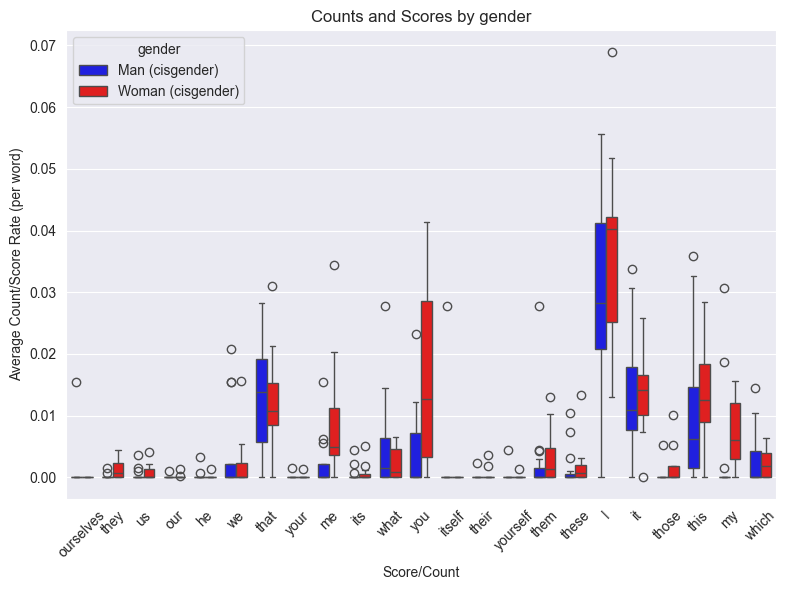

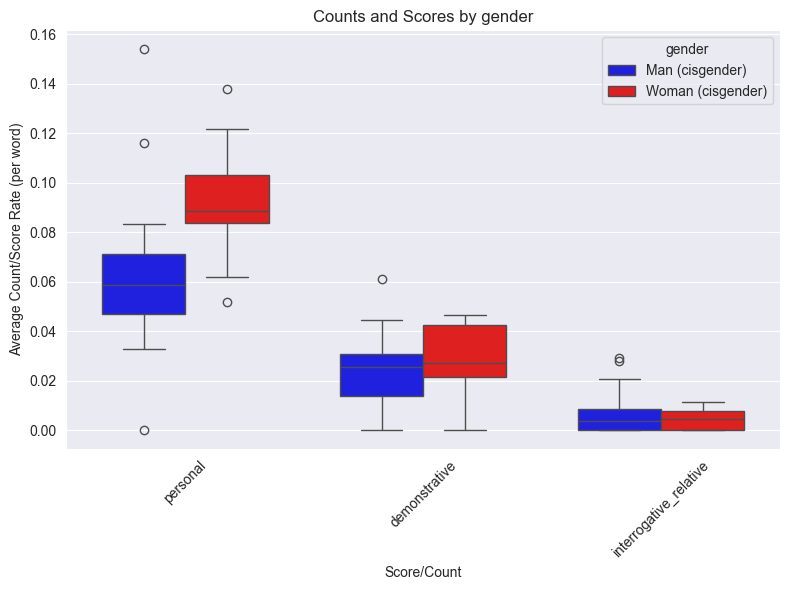

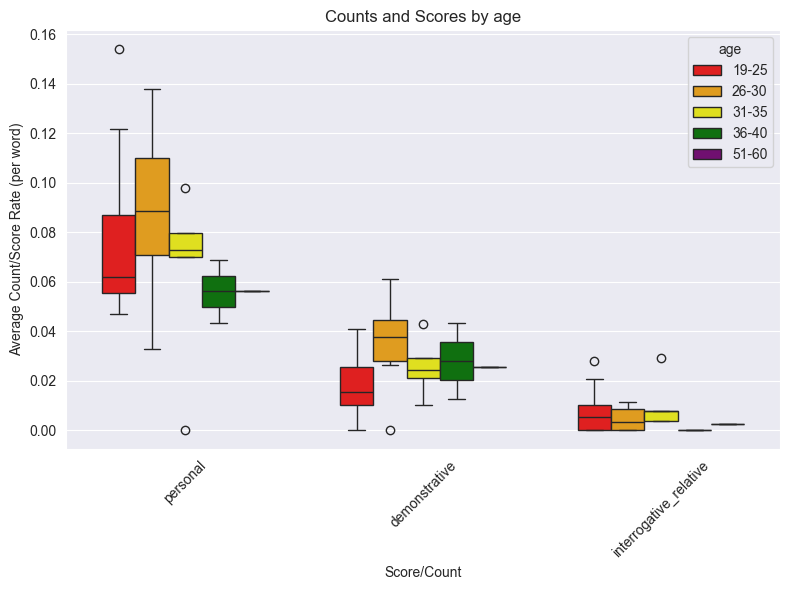

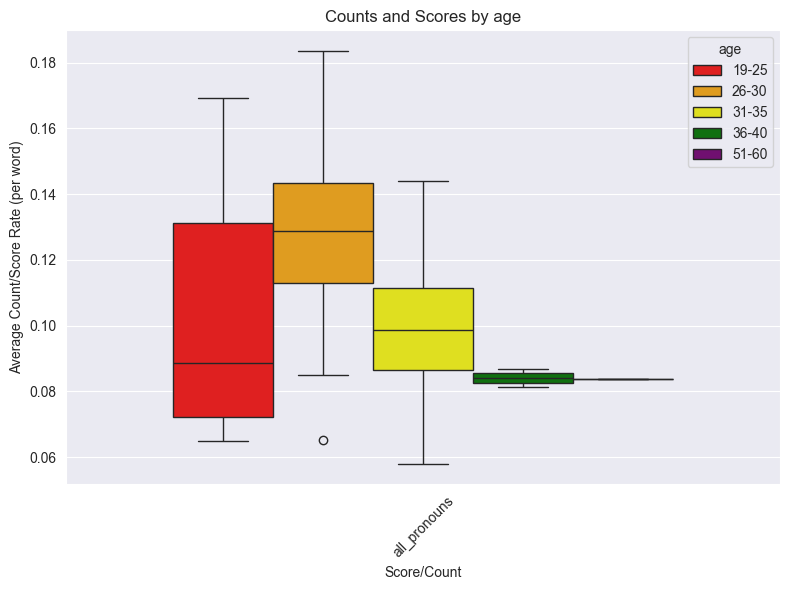

,user_id,gender,age,work_exp_years,conversational,n_words,I,me,my,mine,...,these,those,demonstrative,who,whom,whose,which,what,interrogative_relative,all_pronouns
0,6,Man (cisgender),19-25,3.0,parsing data from python iterator how it could...,192,0.015625,0.000000,0.000000,0.0,...,0.010417,0.005208,0.020833,0.0,0.0,0.0,0.010417,0.010417,0.020833,0.088542
1,8,Man (cisgender),19-25,1.0,i am working on the problem of reconstruc...,36,0.027778,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.027778,0.027778,0.083333
2,11,Woman (cisgender),26-30,1.0,can you adapt the following code so that inste...,193,0.031088,0.005181,0.015544,0.0,...,0.000000,0.005181,0.046632,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.165803
3,15,Man (cisgender),26-30,6.0,setalltables action is currently not fetching ...,36,0.055556,0.000000,0.000000,0.0,...,0.000000,0.000000,0.027778,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.111111
4,16,Woman (cisgender),19-25,None,i want to use dummy hot encoding to replace th...,541,0.051756,0.001848,0.005545,0.0,...,0.001848,0.000000,0.040665,0.0,0.0,0.0,0.003697,0.001848,0.005545,0.131238
5,25,Man (cisgender),26-30,6.0,what is the best way to encode and compress a ...,106,0.028302,0.000000,0.000000,0.0,...,0.000000,0.000000,0.028302,0.0,0.0,0.0,0.000000,0.009434,0.009434,0.084906
6,28,Woman (cisgender),31-35,5.0,i have a pandas dataframe like this i want to...,562,0.039146,0.010676,0.005338,0.0,...,0.001779,0.001779,0.042705,0.0,0.0,0.0,0.003559,0.000000,0.003559,0.144128
7,31,Man (cisgender),36-40,22.0,how can i make use of an observablehqdatabasec...,92,0.032609,0.000000,0.000000,0.0,...,0.000000,0.000000,0.043478,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.086957
8,34,Man (cisgender),51-60,20.0,blender and python i have a collection of hund...,1299,0.020015,0.000000,0.001540,0.0,...,0.003079,0.000000,0.025404,0.0,0.0,0.0,0.000770,0.001540,0.002309,0.083911
9,46,Man (cisgender),31-35,12.0,how to run a python future without blocking ie...,69,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.028986,0.0,0.0,0.0,0.014493,0.014493,0.028986,0.057971


In [15]:
pronoun_types = ['personal', 'demonstrative', 'interrogative_relative']
pronoun_lists = [personal_pronouns, demonstrative_pronouns, interrogative_relative_pronouns]
pronoun_cols = sum(pronoun_lists, [])

pronoun_counts = count(user_prompts, 'all_pronouns', pronoun_types, pronoun_lists)

zero_cols = pronoun_counts.columns[(pronoun_counts.fillna(0.0) == 0.0).all()].tolist()
pronoun_cols = list(set(pronoun_cols) - set(zero_cols))
box_plot(pronoun_counts, ['user_id', 'gender'], pronoun_cols, 'Pronoun', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(pronoun_counts, ['user_id', 'gender'], pronoun_types, 'Pronoun', 'Normalized Rate (100 Words)', 'gender', gender_palette)

box_plot(pronoun_counts, ['age'], pronoun_types, 'Pronoun', 'Normalized Rate (100 Words)', 'age', age_palette)
box_plot(pronoun_counts, ['age'], 'all_pronouns', 'Pronoun', 'Normalized Rate (100 Words)', 'age', age_palette)

pronoun_counts


In [11]:
word_results = groupwise_comparison_with_correction(pronoun_counts, pronoun_cols)
word_results = word_results.sort_values(by="p_value", ascending=True)
word_results

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
8,me,U-test,0.004311,0.099163,9.489545e-05,1.783658e-05,"{'female': 11, 'male': 5}"
11,you,U-test,0.012392,0.114946,2.439991e-04,4.466245e-05,"{'female': 10, 'male': 6}"
21,my,U-test,0.017091,0.114946,3.389834e-05,8.049128e-05,"{'female': 9, 'male': 3}"
1,they,U-test,0.019991,0.114946,3.094365e-06,1.722917e-07,"{'female': 6, 'male': 2}"
19,those,U-test,0.047996,0.220784,9.456442e-06,1.808449e-06,"{'female': 5, 'male': 1}"
15,them,U-test,0.091396,0.350351,1.908545e-05,5.104496e-05,"{'female': 8, 'male': 4}"
16,these,U-test,0.297541,0.734900,1.423376e-05,1.012750e-05,"{'female': 6, 'male': 4}"
17,I,T-test,0.306787,0.734900,2.299495e-04,2.162891e-04,"{'female': 12, 'male': 14}"
20,this,U-test,0.364106,0.734900,7.397405e-05,1.479914e-04,"{'female': 10, 'male': 11}"
2,us,U-test,0.392722,0.734900,1.739213e-06,1.028449e-06,"{'female': 4, 'male': 3}"


In [12]:
group_results = groupwise_comparison_with_correction(pronoun_counts, pronoun_types)
group_results = group_results.sort_values(by="p_value", ascending=True)
group_results

,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
0,personal,T-test,0.023672,0.071016,0.000594,0.001252,"{'female': 12, 'male': 14}"
1,demonstrative,T-test,0.585730,0.742620,0.000233,0.000250,"{'female': 11, 'male': 14}"
2,interrogative_relative,U-test,0.742620,0.742620,0.000019,0.000102,"{'female': 7, 'male': 9}"


In [13]:
overall_results = groupwise_comparison_with_correction(pronoun_counts, ['all_pronouns'])
overall_results = overall_results.sort_values(by="p_value", ascending=True)
overall_results

,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
0,all_pronouns,U-test,0.038099,0.038099,0.000942,0.001271,"{'female': 12, 'male': 15}"


In [24]:
pronoun_types = ['personal', 'demonstrative', 'interrogative_relative']
melted = pronoun_counts.melt(
    id_vars=['user_id', 'gender'],
    value_vars=pronoun_types,
    var_name='pronoun_type',
    value_name='pronoun_rate'
)

model = ols('pronoun_rate ~ gender * pronoun_type', data=melted).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)


                       sum_sq    df          F        PR(>F)
gender               0.003230   1.0   5.363514  2.470239e-02
pronoun_type         0.034082   1.0  56.587406  9.168084e-10
gender:pronoun_type  0.002000   1.0   3.321434  7.436493e-02
Residual             0.030114  50.0        NaN           NaN


## Adjectives

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_9874/674990121.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_9874/674990121.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_9874/674990121.py:10: P

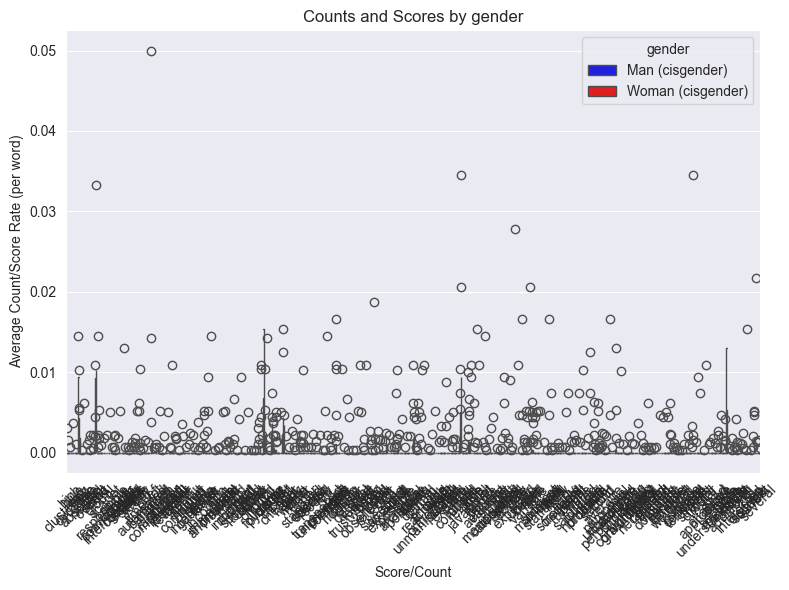

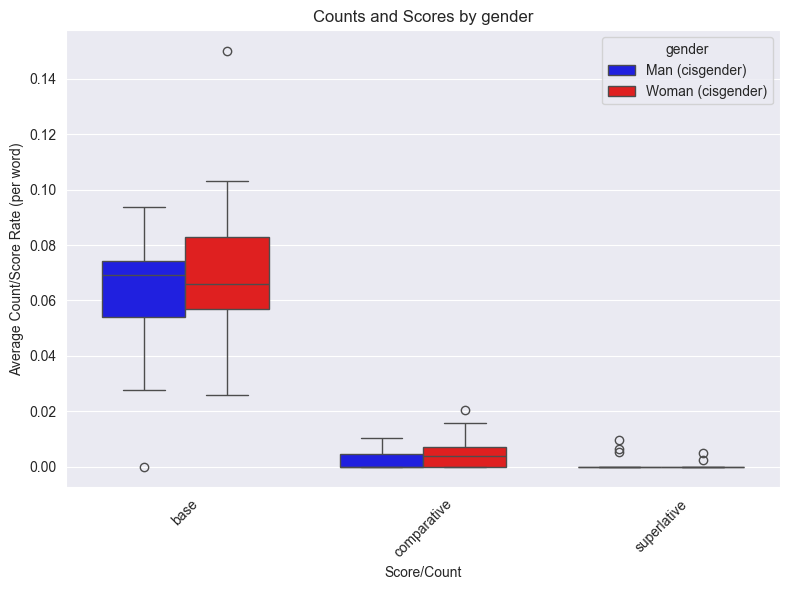

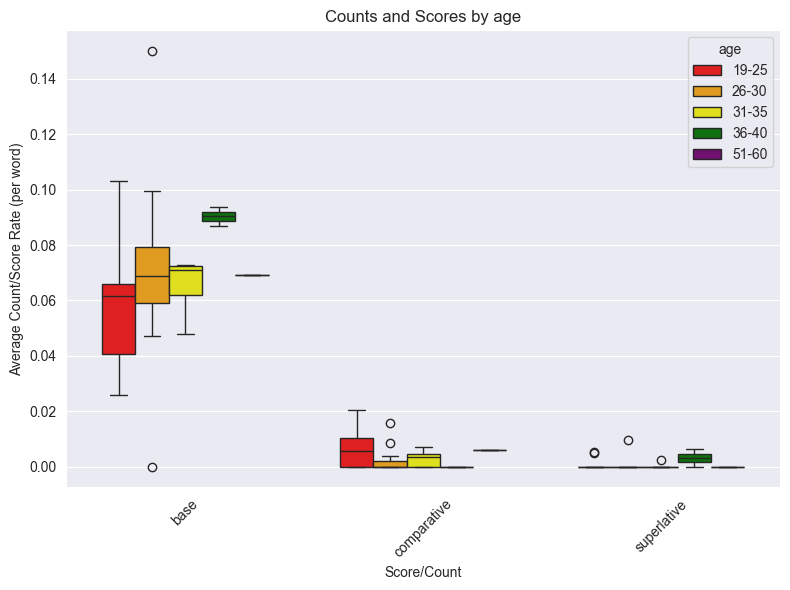

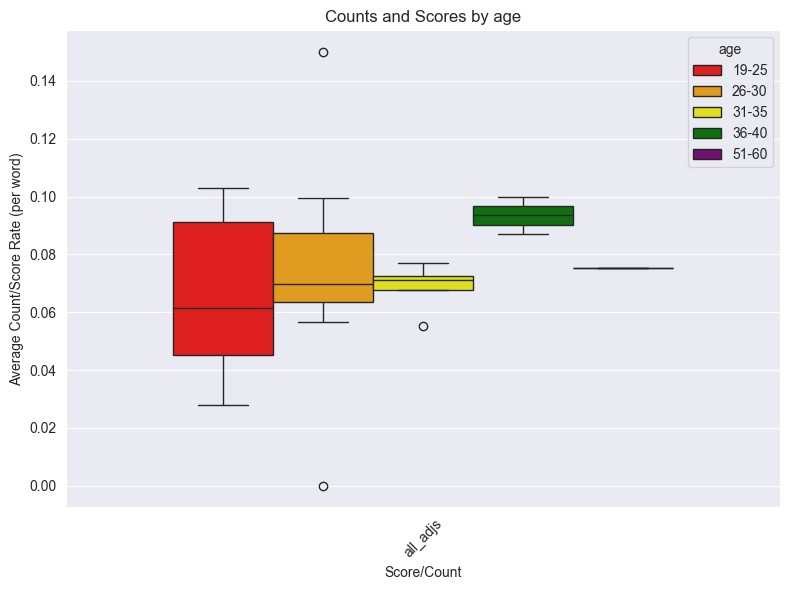

In [42]:
adj_types = ['base', 'comparative', 'superlative']
adj_lists = [base, comparative, superlative]
adj_cols = sum(adj_lists, [])

adj_counts = count(user_prompts, 'all_adjs', adj_types, adj_lists)

zero_cols = adj_counts.columns[(adj_counts.fillna(0.0) == 0.0).all()].tolist()
adj_cols = list(set(adj_cols) - set(zero_cols))
box_plot(adj_counts, ['user_id', 'gender'], adj_cols, 'Adjective', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(adj_counts, ['user_id', 'gender'], adj_types, 'Adjective', 'Normalized Rate (100 Words)', 'gender', gender_palette)

box_plot(adj_counts, ['age'], adj_types, 'Adjective', 'Normalized Rate (100 Words)', 'age', age_palette)
box_plot(adj_counts, ['age'], 'all_adjs', 'Adjective', 'Normalized Rate (100 Words)', 'age', age_palette)

In [43]:
group_results = groupwise_comparison_with_correction(adj_counts, adj_types)
group_results = group_results.sort_values(by="p_value", ascending=True)
group_results

,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
1,comparative,U-test,0.133142,0.399426,0.000045,0.000013,"{'female': 8, 'male': 5}"
0,base,T-test,0.270799,0.406198,0.000940,0.000583,"{'female': 13, 'male': 14}"
2,superlative,U-test,0.629241,0.629241,0.000002,0.000009,"{'female': 2, 'male': 3}"


## Discourse Markers

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_9874/2529627149.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_9874/2529627149.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_9874/2529627149.py:10

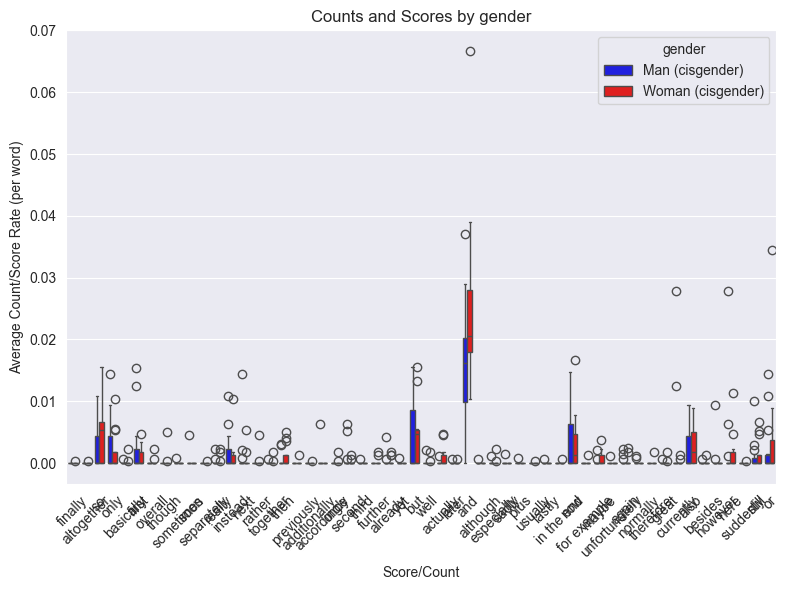

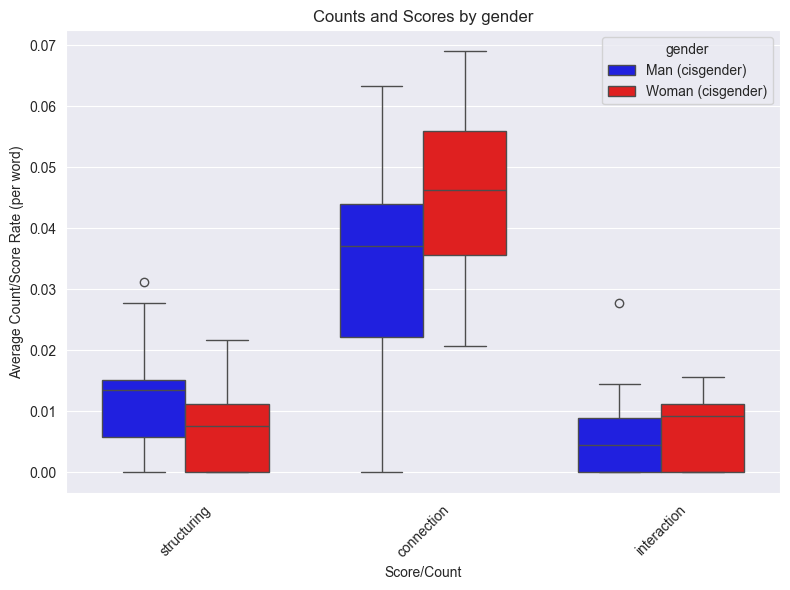

In [13]:
disc_marker_types = ['structuring', 'connection', 'interaction']
disc_marker_lists = [structuring_markers, connection_markers, interaction_markers]
disc_marker_cols = sum(disc_marker_lists, [])

disc_marker_counts = count(user_prompts, 'all_disc_markers', disc_marker_types, disc_marker_lists)

zero_cols = disc_marker_counts.columns[(disc_marker_counts.fillna(0.0) == 0.0).all()].tolist()
disc_marker_cols = list(set(disc_marker_cols) - set(zero_cols))
box_plot(disc_marker_counts, ['user_id', 'gender'], disc_marker_cols, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(disc_marker_counts, ['user_id', 'gender'], disc_marker_types, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)

In [14]:
word_results = groupwise_comparison_with_correction(disc_marker_counts, disc_marker_cols)
word_results = word_results.sort_values(by="p_value", ascending=True)
word_results

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
30,and,U-test,0.058866,0.638434,2.185041e-04,1.039796e-04,"{'female': 13, 'male': 13}"
28,actually,U-test,0.084659,0.638434,2.973913e-06,8.212193e-08,"{'female': 4, 'male': 1}"
16,then,U-test,0.130008,0.638434,3.352455e-06,1.120236e-06,"{'female': 5, 'male': 2}"
6,overall,U-test,0.134805,0.638434,3.967418e-07,0.000000e+00,"{'female': 2, 'male': 0}"
7,though,U-test,0.134805,0.638434,1.969315e-06,0.000000e+00,"{'female': 2, 'male': 0}"
20,once,U-test,0.134805,0.638434,2.438629e-07,0.000000e+00,"{'female': 2, 'male': 0}"
23,further,U-test,0.134805,0.638434,3.515732e-07,0.000000e+00,"{'female': 2, 'male': 0}"
14,rather,U-test,0.134805,0.638434,1.529544e-06,0.000000e+00,"{'female': 2, 'male': 0}"
2,so,U-test,0.174048,0.638434,2.778627e-05,1.397088e-05,"{'female': 8, 'male': 7}"
43,normally,U-test,0.197345,0.638434,0.000000e+00,1.134932e-07,"{'female': 0, 'male': 2}"


In [15]:
group_results = groupwise_comparison_with_correction(disc_marker_counts, disc_marker_types)
group_results = group_results.sort_values(by="p_value", ascending=True)
group_results

,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
1,connection,T-test,0.030731,0.092193,0.000205,0.000353,"{'female': 13, 'male': 13}"
0,structuring,T-test,0.169937,0.254905,0.000047,0.000087,"{'female': 9, 'male': 12}"
2,interaction,U-test,0.601184,0.601184,0.000040,0.000059,"{'female': 8, 'male': 9}"


In [16]:
overall_results = groupwise_comparison_with_correction(disc_marker_counts, ['all_disc_markers'])
overall_results = overall_results.sort_values(by="p_value", ascending=True)
overall_results

,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
0,all_disc_markers,T-test,0.193165,0.193165,0.000251,0.000595,"{'female': 13, 'male': 14}"


## Pragmatic Markers


/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_9874/2529627149.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_9874/2529627149.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_9874/2529627149.py:10

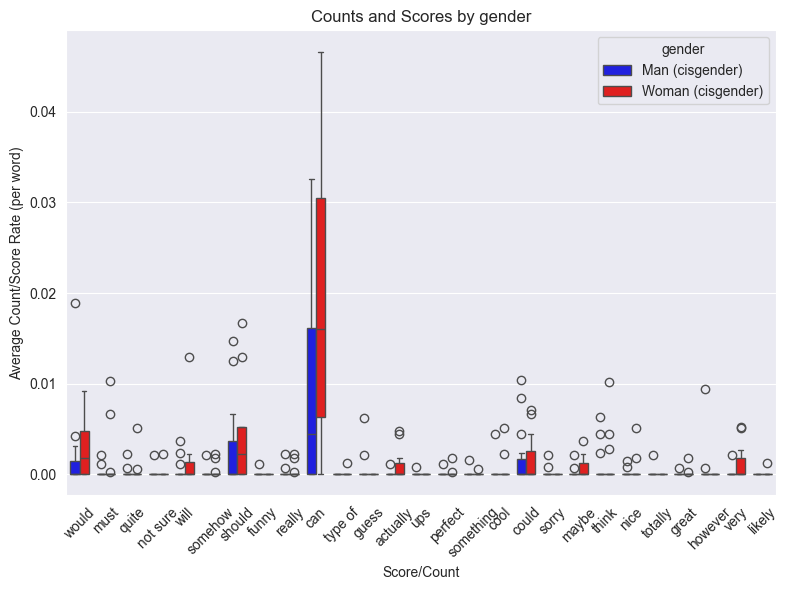

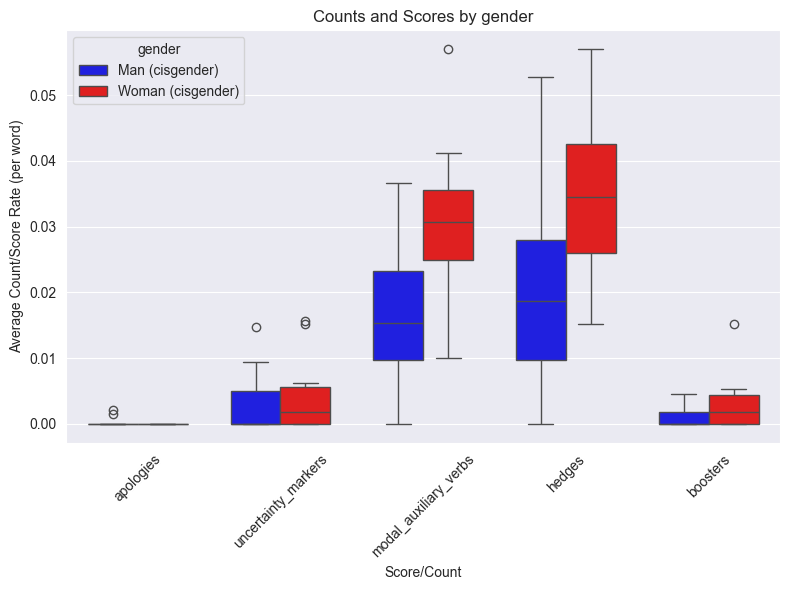

In [17]:
prag_marker_types = ['apologies', 'uncertainty_markers', 'modal_auxiliary_verbs', 'hedges', 'boosters']
prag_marker_lists = [apologies, uncertainty_markers, modal_auxiliary_verbs, hedges, boosters]
prag_marker_cols = sum(prag_marker_lists, [])

prag_marker_counts = count(user_prompts, 'all_prag_markers', prag_marker_types, prag_marker_lists)

zero_cols = prag_marker_counts.columns[(prag_marker_counts.fillna(0.0) == 0.0).all()].tolist()
prag_marker_cols = list(set(prag_marker_cols) - set(zero_cols))
box_plot(prag_marker_counts, ['user_id', 'gender'], prag_marker_cols, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(prag_marker_counts, ['user_id', 'gender'], prag_marker_types, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)

In [18]:
word_results = groupwise_comparison_with_correction(prag_marker_counts, prag_marker_cols)
word_results = word_results.sort_values(by="p_value", ascending=True)
word_results

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
25,very,U-test,0.046671,0.629165,3.754168e-06,2.967236e-07,"{'female': 5, 'male': 1}"
9,can,U-test,0.069131,0.629165,2.019893e-04,1.156653e-04,"{'female': 11, 'male': 9}"
12,actually,U-test,0.084659,0.629165,2.973913e-06,8.212193e-08,"{'female': 4, 'male': 1}"
0,would,U-test,0.161004,0.629165,8.151579e-06,2.372984e-05,"{'female': 8, 'male': 5}"
24,however,U-test,0.197345,0.629165,0.000000e+00,5.903276e-06,"{'female': 0, 'male': 2}"
18,sorry,U-test,0.197345,0.629165,0.000000e+00,3.207645e-07,"{'female': 0, 'male': 2}"
11,guess,U-test,0.197345,0.629165,0.000000e+00,2.775313e-06,"{'female': 0, 'male': 2}"
4,will,U-test,0.201485,0.629165,1.248739e-05,1.190959e-06,"{'female': 6, 'male': 3}"
19,maybe,U-test,0.235169,0.629165,1.451084e-06,3.178676e-07,"{'female': 4, 'male': 2}"
6,should,U-test,0.249568,0.629165,2.792143e-05,2.360048e-05,"{'female': 8, 'male': 5}"


In [19]:
group_results = groupwise_comparison_with_correction(prag_marker_counts, prag_marker_types)
group_results = group_results.sort_values(by="p_value", ascending=True)
group_results

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
2,modal_auxiliary_verbs,T-test,0.010130,0.039915,0.000156,1.494862e-04,"{'female': 13, 'male': 12}"
3,hedges,T-test,0.015966,0.039915,0.000169,2.471991e-04,"{'female': 13, 'male': 12}"
0,apologies,U-test,0.197345,0.252214,0.000000,4.238223e-07,"{'female': 0, 'male': 2}"
4,boosters,U-test,0.201771,0.252214,0.000018,3.431416e-06,"{'female': 7, 'male': 5}"
1,uncertainty_markers,U-test,0.548020,0.548020,0.000031,2.110795e-05,"{'female': 7, 'male': 6}"


In [22]:
overall_results = groupwise_comparison_with_correction(prag_marker_counts, ['all_prag_markers'])
overall_results = overall_results.sort_values(by="p_value", ascending=True)
overall_results

,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
0,all_prag_markers,T-test,0.015746,0.015746,0.000817,0.001055,"{'female': 13, 'male': 12}"


## Interactions


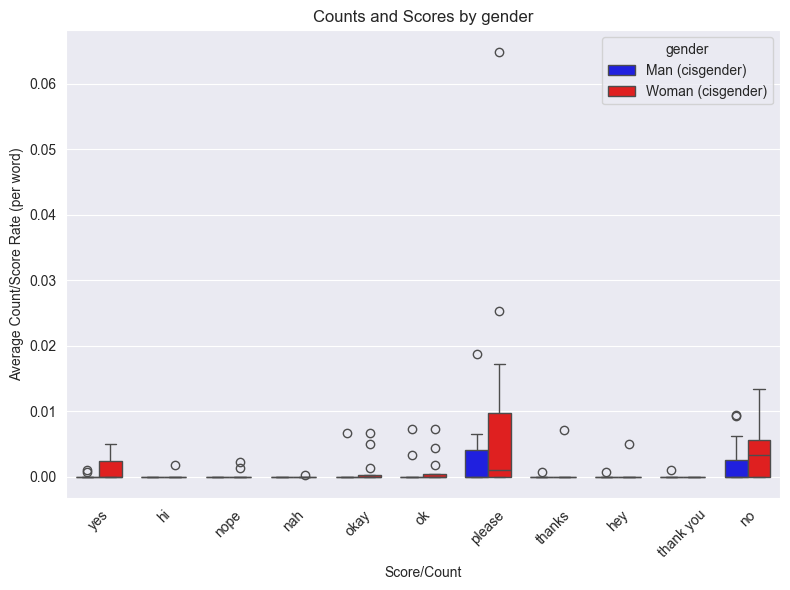

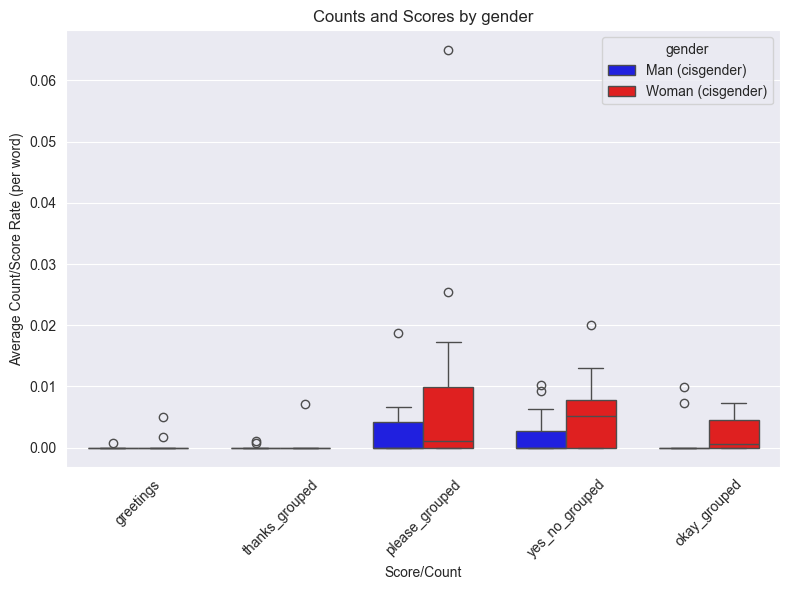

,user_id,gender,age,work_exp_years,conversational,n_words,hey,hi,hello,greetings,...,please_grouped,yes,no,nah,nope,yes_no_grouped,okay,ok,okay_grouped,all_int_markers
0,6,Man (cisgender),19-25,3.0,"parsing data from python iterator, how it coul...",196,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,8,Man (cisgender),19-25,1.0,\n i am working on the problem of reconstru...,36,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,11,Woman (cisgender),26-30,1.0,can you adapt the following code so that inste...,194,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,15,Man (cisgender),26-30,6.0,set_all_tables action is currently not fetchin...,36,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,16,Woman (cisgender),19-25,None,i want to use dummy hot encoding to replace th...,544,0.000000,0.000000,0.0,0.000000,...,0.007353,0.001838,0.003676,0.000000,0.000000,0.005515,0.000000,0.007353,0.007353,0.020221
5,25,Man (cisgender),26-30,6.0,what is the best way to encode and compress a ...,108,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.009259,0.000000,0.000000,0.009259,0.000000,0.000000,0.000000,0.009259
6,28,Woman (cisgender),31-35,5.0,i have a pandas dataframe like this:\n\ni want...,562,0.000000,0.001779,0.0,0.001779,...,0.007117,0.000000,0.005338,0.000000,0.000000,0.005338,0.000000,0.001779,0.001779,0.023132
7,31,Man (cisgender),36-40,22.0,how can i make use of an observablehqdatabasec...,92,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,34,Man (cisgender),51-60,20.0,blender and python. i have a collection of hun...,1309,0.000000,0.000000,0.0,0.000000,...,0.003820,0.000000,0.003056,0.000000,0.000000,0.003056,0.000000,0.000000,0.000000,0.006875
9,46,Man (cisgender),31-35,12.0,"how to run a python future without blocking, i...",69,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [39]:
int_marker_types = ['greetings', 'thanks_grouped', 'please_grouped', 'yes_no_grouped', 'okay_grouped']
int_marker_lists = [greetings, thanks_grouped, please_grouped, yes_no_grouped, okay_grouped]
int_marker_cols = sum(int_marker_lists, [])

int_marker_counts = count(user_prompts, 'all_int_markers', int_marker_types, int_marker_lists)

zero_cols = int_marker_counts.columns[(int_marker_counts.fillna(0.0) == 0.0).all()].tolist()
int_marker_cols = list(set(int_marker_cols) - set(zero_cols))
box_plot(int_marker_counts, ['user_id', 'gender'], int_marker_cols, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(int_marker_counts, ['user_id', 'gender'], int_marker_types, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)

int_marker_counts

In [40]:
word_results = groupwise_comparison_with_correction(int_marker_counts, int_marker_cols)
word_results = word_results.sort_values(by="p_value", ascending=True)
word_results

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
0,yes,U-test,0.076279,0.466270,4.655860e-06,1.092357e-07,"{'female': 5, 'male': 2}"
2,nope,U-test,0.119340,0.466270,5.158452e-07,0.000000e+00,"{'female': 2, 'male': 0}"
4,okay,U-test,0.221170,0.466270,5.264069e-06,2.930313e-06,"{'female': 3, 'male': 1}"
10,no,U-test,0.226505,0.466270,2.343186e-05,1.176183e-05,"{'female': 7, 'male': 6}"
6,please,U-test,0.238593,0.466270,3.619308e-04,2.591654e-05,"{'female': 6, 'male': 5}"
1,hi,U-test,0.296718,0.466270,2.638433e-07,0.000000e+00,"{'female': 1, 'male': 0}"
3,nah,U-test,0.296718,0.466270,8.199401e-09,0.000000e+00,"{'female': 1, 'male': 0}"
9,thank you,U-test,0.412278,0.566882,0.000000e+00,8.139760e-08,"{'female': 0, 'male': 1}"
5,ok,U-test,0.471580,0.576375,5.570530e-06,4.054092e-06,"{'female': 3, 'male': 2}"
7,thanks,U-test,0.871994,0.871994,4.221493e-06,3.551956e-08,"{'female': 1, 'male': 1}"


In [41]:
group_results = groupwise_comparison_with_correction(int_marker_counts, int_marker_types)
group_results = group_results.sort_values(by="p_value", ascending=True)
group_results

,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
3,yes_no_grouped,U-test,0.082955,0.241381,0.000039,1.248854e-05,"{'female': 8, 'male': 6}"
4,okay_grouped,U-test,0.096552,0.241381,0.000008,9.453834e-06,"{'female': 6, 'male': 2}"
2,please_grouped,U-test,0.238593,0.397655,0.000362,2.591654e-05,"{'female': 6, 'male': 5}"
0,greetings,U-test,0.395731,0.494664,0.000002,3.551956e-08,"{'female': 2, 'male': 1}"
1,thanks_grouped,U-test,0.788553,0.788553,0.000004,1.092357e-07,"{'female': 1, 'male': 2}"


In [26]:
overall_results = groupwise_comparison_with_correction(int_marker_counts, ['all_int_markers'])
overall_results = overall_results.sort_values(by="p_value", ascending=True)
overall_results

,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
0,all_int_markers,U-test,0.109586,0.109586,0.000507,0.000088,"{'female': 8, 'male': 6}"


## Slang

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_9874/2529627149.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_9874/2529627149.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_9874/2529627149.py:11

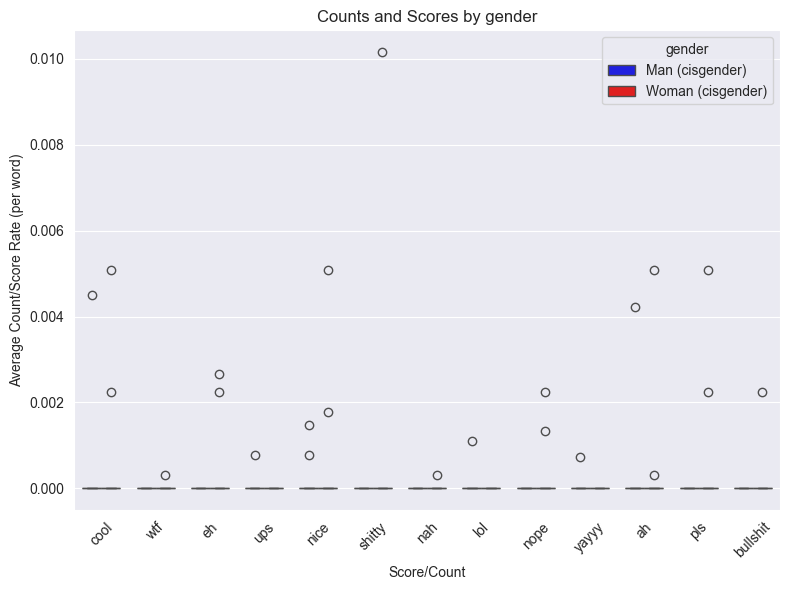

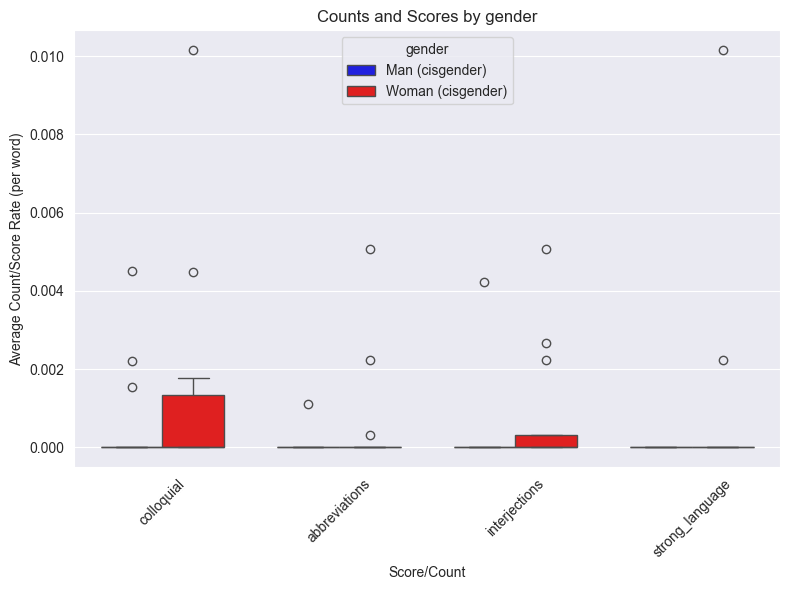

In [27]:
inf_marker_types = ['colloquial', 'abbreviations', 'interjections', 'strong_language']
inf_marker_lists = [colloquial, abbreviations, interjections, strong_language]
inf_marker_cols = sum(inf_marker_lists, [])

inf_marker_counts = count(user_prompts, 'all_inf_markers', inf_marker_types, inf_marker_lists)

zero_cols = inf_marker_counts.columns[(inf_marker_counts.fillna(0.0) == 0.0).all()].tolist()
inf_marker_cols = list(set(inf_marker_cols) - set(zero_cols))
box_plot(inf_marker_counts, ['user_id', 'gender'], inf_marker_cols, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(inf_marker_counts, ['user_id', 'gender'], inf_marker_types, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)

In [28]:
word_results = groupwise_comparison_with_correction(inf_marker_counts, inf_marker_cols)
word_results = word_results.sort_values(by="p_value", ascending=True)
word_results

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
2,eh,U-test,0.134805,0.507200,8.568678e-07,0.000000e+00,"{'female': 2, 'male': 0}"
8,nope,U-test,0.134805,0.507200,4.838079e-07,0.000000e+00,"{'female': 2, 'male': 0}"
11,pls,U-test,0.134805,0.507200,2.221487e-06,0.000000e+00,"{'female': 2, 'male': 0}"
1,wtf,U-test,0.316073,0.507200,7.382264e-09,0.000000e+00,"{'female': 1, 'male': 0}"
5,shitty,U-test,0.316073,0.507200,7.928375e-06,0.000000e+00,"{'female': 1, 'male': 0}"
6,nah,U-test,0.316073,0.507200,7.382264e-09,0.000000e+00,"{'female': 1, 'male': 0}"
12,bullshit,U-test,0.316073,0.507200,3.849830e-07,0.000000e+00,"{'female': 1, 'male': 0}"
3,ups,U-test,0.390154,0.507200,0.000000e+00,3.950849e-08,"{'female': 0, 'male': 1}"
7,lol,U-test,0.390154,0.507200,0.000000e+00,8.212193e-08,"{'female': 0, 'male': 1}"
9,yayyy,U-test,0.390154,0.507200,0.000000e+00,3.588534e-08,"{'female': 0, 'male': 1}"


In [29]:
group_results = groupwise_comparison_with_correction(inf_marker_counts, inf_marker_types)
group_results = group_results.sort_values(by="p_value", ascending=True)
group_results

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
2,interjections,U-test,0.129177,0.269610,0.000002,1.186894e-06,"{'female': 4, 'male': 1}"
3,strong_language,U-test,0.134805,0.269610,0.000008,0.000000e+00,"{'female': 2, 'male': 0}"
1,abbreviations,U-test,0.225975,0.301301,0.000002,8.212193e-08,"{'female': 3, 'male': 1}"
0,colloquial,U-test,0.355388,0.355388,0.000009,1.640957e-06,"{'female': 5, 'male': 3}"


In [31]:
overall_result = groupwise_comparison_with_correction(inf_marker_counts, ['all_inf_markers'])
overall_result = overall_result.sort_values(by="p_value", ascending=True)
overall_result

,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
0,all_inf_markers,U-test,0.70679,0.70679,0.000074,0.000002,"{'female': 5, 'male': 5}"
